In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import re

In [5]:
company = pd.read_excel("/Users/asa/VScode/similarity/data/company.xlsx")
patent = pd.read_csv("/Users/asa/VScode/similarity/data/patent.csv")
literature = pd.read_csv("/Users/asa/VScode/similarity/data/literature.csv")

----------------

In [19]:
import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
import re

def tokenize_keywords(keywords, tokenizer):
    """Tokenize keywords for BERT."""
    tokens = tokenizer("[SEP]".join(keywords), return_tensors="pt", padding=True, truncation=True)
    return tokens

def preprocess_text(text):
    """Normalize and process text, keeping commas."""
    return re.sub(r'[^\w\s,]', '', text.lower())


def compute_tfidf_weights(keywords, max_features=5000):
    """Compute TF-IDF for keywords."""
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, max_df=0.5, min_df=2, stop_words='english', sublinear_tf=True, ngram_range=(1, 3))
    tfidf_vectors = tfidf_vectorizer.fit_transform(keywords)
    print(f"TF-IDF vector size: {tfidf_vectors.shape}")
    return tfidf_vectors, tfidf_vectorizer
    
class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(feature_dim))

    def forward(self, x):
        scores = torch.matmul(x, self.attention_weights)
        attention_weights = torch.softmax(scores, dim=-1)
        attended_features = x * attention_weights.unsqueeze(-1)
        return attended_features.sum(dim=1)

def get_concatenated_embeddings_with_attention(model, tokenizer, keywords, attention_layer, device):
    embeddings = []
    print(f"Number of keywords: {len(keywords)}")  # Debug: print number of keywords being processed

    for keyword in keywords:
        tokens = tokenize_keywords([keyword], tokenizer)
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            outputs = model(**tokens)
            last_hidden_state = outputs.last_hidden_state

        attention_output = attention_layer(last_hidden_state)
        if attention_output.dim() == 3:
            max_pooled_embedding = torch.max(attention_output, dim=1).values
        elif attention_output.dim() == 2:
            max_pooled_embedding = attention_output.squeeze(0)
        else:
            raise ValueError("Unexpected attention output dimensions:", attention_output.shape)

        if max_pooled_embedding.dim() == 1:
            max_pooled_embedding = max_pooled_embedding.unsqueeze(0)
        
        print(f"Keyword: {keyword}, Embedding shape: {max_pooled_embedding.shape}")  # Debug: print each embedding's shape
        embeddings.append(max_pooled_embedding)

    if len(embeddings) > 1:
        concatenated_embeddings = torch.cat(embeddings, dim=1)
        print(f"Concatenated embeddings shape: {concatenated_embeddings.shape}")  # Debug: print the final concatenated shape
    else:
        concatenated_embeddings = embeddings[0] if embeddings else torch.tensor([])

    return concatenated_embeddings

def calculate_embeddings_with_attention(groups, dataset_name, model, tokenizer, attention_layer, device):
    embeddings_dict = {}
    model = model.to(device)
    attention_layer = attention_layer.to(device)

    all_keywords = [preprocess_text(row['keywords']) for _, group in groups for _, row in group.iterrows()]
    tfidf_weights, _ = compute_tfidf_weights(all_keywords)

    idx = 0
    for key, group in tqdm(groups, desc=f"Processing groups for {dataset_name}"):
        group_embeddings = []
        for _, row in tqdm(group.iterrows(), total=group.shape[0], desc=f"Processing rows for group {key}"):
            keywords = preprocess_text(row['keywords']).split(", ")
            bert_embeddings = get_concatenated_embeddings_with_attention(model, tokenizer, keywords, attention_layer, device)
            tfidf_embedding = torch.tensor(tfidf_weights[idx].toarray()).squeeze()  # Remove unnecessary dimensions
            if tfidf_embedding.dim() == 0:  # If squeezing leads to a scalar, unsqueeze it twice to get a 2D tensor
                tfidf_embedding = tfidf_embedding.unsqueeze(0).unsqueeze(0)
            elif tfidf_embedding.dim() == 1:  # If squeezing leads to a 1D tensor, unsqueeze it once
                tfidf_embedding = tfidf_embedding.unsqueeze(0)
            concatenated_embedding = torch.cat([bert_embeddings, tfidf_embedding], dim=-1)
            group_embeddings.append(concatenated_embedding.unsqueeze(0))
            print(f"Final concatenated embedding size for group '{key}': {concatenated_embedding.shape}")
            idx += 1

        if group_embeddings:
            average_embeddings = torch.mean(torch.cat(group_embeddings, dim=0), dim=0)
            embeddings_dict[key] = average_embeddings.detach().cpu().numpy()
            print(f"Average embedding size for group '{key}': {average_embeddings.shape}")

    return embeddings_dict



In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
attention_layer = Attention(feature_dim=model.config.hidden_size).to(device)

embeddings_dict_company = calculate_embeddings_with_attention(company.groupby('cluster'), 'company', model, tokenizer, attention_layer, device)
embeddings_dict_patent = calculate_embeddings_with_attention(patent.groupby('cluster'), 'patent', model, tokenizer, attention_layer, device)
embeddings_dict_literature = calculate_embeddings_with_attention(literature.groupby('type'), 'literature', model, tokenizer, attention_layer, device)


AttributeError: 'float' object has no attribute 'lower'

# L2 regularization 其实就是l2范数的归一化

In [92]:
from sklearn.preprocessing import normalize

def normalize_embeddings(embeddings):
    # embeddings应为一个二维数组，其中axis=0为批次维，axis=1为特征维
    normalized_embeddings = normalize(embeddings, norm='l2', axis=1)
    return normalized_embeddings


In [93]:
# 应用L2正则化
for key, embedding in embeddings_dict_company.items():
    normalized_embedding = normalize_embeddings(embedding.reshape(1, -1))  # reshape是因为我们需要二维输入
    embeddings_dict_company[key] = normalized_embedding

for key, embedding in embeddings_dict_patent.items():
    normalized_embedding = normalize_embeddings(embedding.reshape(1, -1))  # reshape是因为我们需要二维输入
    embeddings_dict_patent[key] = normalized_embedding

for key, embedding in embeddings_dict_literature.items():
    normalized_embedding = normalize_embeddings(embedding.reshape(1, -1))  # reshape是因为我们需要二维输入
    embeddings_dict_literature[key] = normalized_embedding


In [94]:
# Debugging: Print shapes to ensure correctness
for key, emb in embeddings_dict_company.items():
    print(f"Shape for {key} in company group: {emb.shape}")
for key, emb in embeddings_dict_patent.items():
    print(f"Shape for {key} in patent group: {emb.shape}")
for key, emb in embeddings_dict_literature.items():
    print(f"Shape for {key} in literature group: {emb.shape}")


Shape for 0 in company group: (1, 3721)
Shape for 1 in company group: (1, 3721)
Shape for 2 in company group: (1, 3721)
Shape for 3 in company group: (1, 3721)
Shape for 4 in company group: (1, 3721)
Shape for 0 in patent group: (1, 5826)
Shape for 1 in patent group: (1, 5826)
Shape for 2 in patent group: (1, 5826)
Shape for 3 in patent group: (1, 5826)
Shape for 4 in patent group: (1, 5826)
Shape for 5 in patent group: (1, 5826)
Shape for a in literature group: (1, 5768)
Shape for b in literature group: (1, 5768)
Shape for c in literature group: (1, 5768)
Shape for d in literature group: (1, 5768)
Shape for e in literature group: (1, 5768)
Shape for f in literature group: (1, 5768)
Shape for g in literature group: (1, 5768)


# PCA

In [100]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

def apply_pca(data, n_components=0.95):
    """Apply PCA to given data without additional scaling."""
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

# Prepare embeddings from all groups for PCA
# Assuming that embeddings_dict_company, etc., are dictionaries of numpy arrays
company_embeddings = np.vstack(list(embeddings_dict_company.values()))
patent_embeddings = np.vstack(list(embeddings_dict_patent.values()))
literature_embeddings = np.vstack(list(embeddings_dict_literature.values()))

# Apply PCA directly on normalized embeddings
company_pca, pca_company = apply_pca(company_embeddings)
patent_pca, pca_patent = apply_pca(patent_embeddings)
literature_pca, pca_literature = apply_pca(literature_embeddings)

# Align dimensions to the smallest dimension across PCA outputs
min_dimension = min(company_pca.shape[1], patent_pca.shape[1], literature_pca.shape[1])
company_pca = company_pca[:, :min_dimension]
patent_pca = patent_pca[:, :min_dimension]
literature_pca = literature_pca[:, :min_dimension]
print("Aligned dimensions:", min_dimension)

def compute_similarity_matrix(embeddings1, embeddings2):
    """Compute cosine similarity matrix and adjust values to be between 0 and 1."""
    similarity_matrix = cosine_similarity(embeddings1, embeddings2)
    # Adjusting the range from [-1, 1] to [0, 1]
    adjusted_similarity_matrix = (similarity_matrix +1 ) / 2 
    return pd.DataFrame(adjusted_similarity_matrix, columns=[f"Lit_{i}" for i in range(embeddings2.shape[0])],
                        index=[f"Comp_{i}" for i in range(embeddings1.shape[0])])

# Compute and print adjusted similarity matrices
similarity_matrix0 = compute_similarity_matrix(company_pca, patent_pca)
similarity_matrix1 = compute_similarity_matrix(patent_pca, literature_pca)

print(similarity_matrix0.head())
print(similarity_matrix1.head())


# Optionally, save the similarity matrix to a CSV file
similarity_matrix0.to_csv('cosine_similarity_matrix_company_patent.csv')
similarity_matrix1.to_csv('cosine_similarity_matrix_patent_literature.csv')


Aligned dimensions: 4
           Lit_0     Lit_1     Lit_2     Lit_3     Lit_4     Lit_5
Comp_0  0.702699  0.083918  0.621184  0.878167  0.439232  0.190366
Comp_1  0.285467  0.579316  0.905109  0.171187  0.321197  0.625112
Comp_2  0.170786  0.428990  0.194225  0.678320  0.651628  0.881134
Comp_3  0.759763  0.828197  0.235435  0.581648  0.278772  0.334737
Comp_4  0.580269  0.736568  0.423630  0.112401  0.845358  0.528020
           Lit_0     Lit_1     Lit_2     Lit_3     Lit_4     Lit_5     Lit_6
Comp_0  0.652394  0.715734  0.663452  0.076982  0.555964  0.461844  0.441899
Comp_1  0.063027  0.453300  0.866009  0.572953  0.654476  0.214601  0.974515
Comp_2  0.618287  0.112104  0.142537  0.520193  0.841668  0.605441  0.325340
Comp_3  0.894029  0.678848  0.548772  0.212791  0.077264  0.902785  0.276187
Comp_4  0.439260  0.834593  0.368472  0.707988  0.488637  0.176652  0.340095


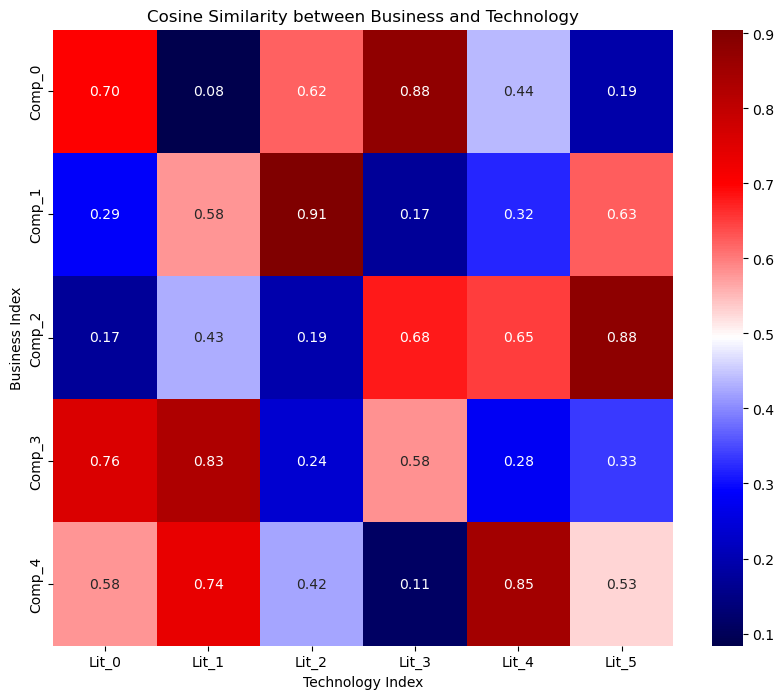

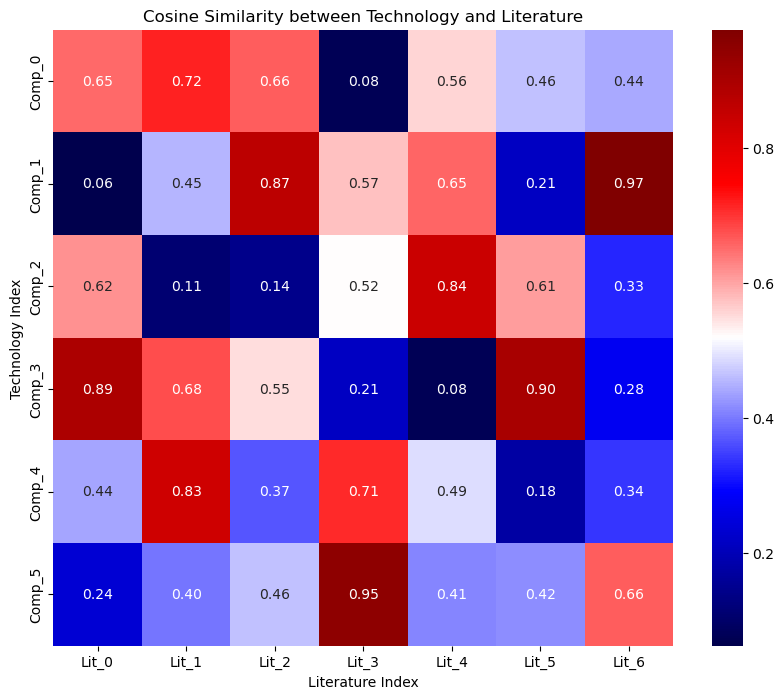

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


similarity_matrix2 = pd.read_csv('cosine_similarity_matrix_company_patent.csv', index_col=0)
similarity_matrix3 = pd.read_csv('cosine_similarity_matrix_patent_literature.csv', index_col=0)


def plot_heatmap(similarity_matrix, title, xlabel, ylabel):
    """Plot a heatmap for the similarity matrix using a white to red color map."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='seismic', cbar=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Assuming similarity_matrix0 and similarity_matrix1 are already computed
plot_heatmap(similarity_matrix2, 'Cosine Similarity between Business and Technology', xlabel='Technology Index', ylabel= 'Business Index' )
plot_heatmap(similarity_matrix3, 'Cosine Similarity between Technology and Literature', xlabel='Literature Index', ylabel= 'Technology Index')
